# The Rosendrock method

Usually in real-world-problems one encounters a system of differential equations, which does not behave nicely. Such systems are called *stiff*, and basically it means that it becomes expensive for an adaptive method to find a small enough stepsize so that the solution does not explode. 

As far aas know implicit methods are best, i.e. methods where one has to solve an equation of the form
$$ F(\vec{k}_1 ,\vec{k}_2,\vec{k}_3 \cdots ) = G(\vec{k}_1 ,\vec{k}_2,\vec{k}_3 \cdots ),$$
which also becomes expensive and difficult to implement. 


However, there is one method that can give nice results fairly cheaply, and is called the Rosendrock method.

Lets assume, as usual, that we have a differential equation
$$
\dfrac{d\vec{y}}{dt}=\vec{f}(\vec{y},t) \;,
$$
with  given $\vec{y}(0)$ (as always $t \in [0,1]$). In quite involveed methods, in order to simplify 
the notation, we take $t$ as a component of $\vec{y}$. So if we have $N$ differential equations with
explicit t-dependence, we now have $N+1$, for which $y_{N+1}=t$ with $\dfrac{dy_{N+1}}{dt}=1$ and $t_0 =0$.
Doing so, we can follow the RK algorithms, and  $t_{n+1}=t_{n}+h$, $\sum_i b_i =1$, $c_i \sum_i a_{ji}$, 
we find that $k_{N+1,i}=h$. 


So it suffices to study the solution of

$$
\dfrac{d\vec{y}}{dt}=\vec{f}(\vec{y}) \;,
$$
i.e remove the explicit t dependence. We follow then the standard iteration:

$$
\vec{y}_{n+1}=\vec{y}_{n}+ \sum_{i=1}^{s} b_i \vec{k}_i \\
\vec{y}^{\star}_{n+1}=\vec{y}_{n}+ \sum_{i=1}^{s} b_i^{\star} \vec{k}_i \;.
$$

The Rosenbrock method says that the $\vec{k}$'s are given by

$$
\left(\hat I - \gamma_i h \hat J \right)\cdot \vec{k}_i =  
h \vec{f}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j} \Big)+
h \hat J \cdot \sum_{j=1}^{i-1}\gamma_{ij}\vec{k}_{j},
$$
where the  $\alpha, b, c$, and $\gamma$ parameters define the method, $\hat I$ is the $(N+1,N+1)$ unit matrix,
and $\hat J =\dfrac{\partial \vec{f}}{\partial \vec{y}}\Bigg|_{\vec{y}=\vec{y}_n} $ is the Jacobian of the system.
Particularly interested methods include those with $\gamma_i=\gamma \; \forall i$, since we can just calculate the LU-factorisation of $\left(\hat I - \gamma h \hat J \right)$ once in every step. This is the case in which I'm focusing here.


Introducing the indices, the left-hand-side of the equation for the $\vec{k}$s becomes

$$
\left(\hat I - \gamma h \hat J \right)\cdot \vec{k}_i =  
\sum_{\beta=1}^{N+1}
\left(\delta_{\alpha \beta} - \gamma h \dfrac{\partial f_{\alpha}}{\partial y_{\beta}}\right)k_{\beta,i}=
\sum_{\beta=1}^{N}
\left(\delta_{\alpha \beta} - \gamma h \dfrac{\partial f_{\alpha}}{\partial y_{\beta}}\right)k_{\beta,i}+
\left(\delta_{\alpha N+1} - \gamma h^2 \dfrac{\partial f_{\alpha}}{\partial t}\right)\;.
$$
The right-hand-side is

$$
h \vec{f}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j} \Big)+
h \hat J \cdot \sum_{j=1}^{i-1}\gamma_{ij}\vec{k}_{j}=
h f_{\alpha}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j},t_n + c_{i}h \Big)+
h \sum_{\beta=1}^{N+1}  \dfrac{\partial f_{\alpha}}{\partial y_{\beta}} \sum_{j=1}^{i-1}\gamma_{ij} k_{\beta,j}=\\
h f_{\alpha}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j}, t_n + c_{i}h\Big)+
h \sum_{\beta=1}^{N}  \dfrac{\partial f_{\alpha}}{\partial y_{\beta}} \sum_{j=1}^{i-1}\gamma_{ij} k_{\beta,j}+
h^2\dfrac{\partial f_{\alpha}}{\partial t} \sum_{j=1}^{i-1}\gamma_{ij}\;. 
$$
These two give us 

$$
\sum_{\beta=1}^{N}
\left(\delta_{\alpha \beta} - \gamma h^2 \dfrac{\partial f_{\alpha}}{\partial y_{\beta}}\right)k_{\beta,i}+
\left(\delta_{\alpha N+1} - \gamma h \dfrac{\partial f_{\alpha}}{\partial t}\right)=
h f_{\alpha}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j},t_n + c_{i}h \Big)+
h \sum_{\beta=1}^{N}  \dfrac{\partial f_{\alpha}}{\partial y_{\beta}} \sum_{j=1}^{i-1}\gamma_{ij} k_{\beta,j}+
h^2\dfrac{\partial f_{\alpha}}{\partial t} \sum_{j=1}^{i-1}\gamma_{ij} \Rightarrow \\
%
\sum_{\beta=1}^{N}
\left(\delta_{\alpha \beta} - \gamma h \dfrac{\partial f_{\alpha}}{\partial y_{\beta}}\right)k_{\beta,i}=
h f_{\alpha}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j},t_n + c_{i}h \Big)+
h^2\left(\gamma + \sum_{j=1}^{i-1}\gamma_{ij}\right) \dfrac{\partial f_{\alpha}}{\partial t}+
h \sum_{\beta=1}^{N}  \dfrac{\partial f_{\alpha}}{\partial y_{\beta}} \sum_{j=1}^{i-1}\gamma_{ij} k_{\beta,j}
\Rightarrow \\
\left(\hat I - \gamma h \hat J\right)\cdot \vec{k}_{i}=
h \vec{f}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j},t_n + c_{i}h \Big)+
h^2\left(\gamma + \sum_{j=1}^{i-1}\gamma_{ij}\right)\dfrac{\partial \vec{f} }{\partial t}+
h \hat J \cdot \sum_{j=1}^{i-1}\gamma_{ij} \vec{k}_{j}\; ,
$$

where we have used that $\delta_{a,N+1}=0$, since we know that $k_{N+1,i}=h$. 

To recap, the Rosenbrock method solves differential equations using 

$$
\vec{y}_{n+1}=\vec{y}_{n}+ \sum_{i=1}^{s} b_i \vec{k}_i \\
\vec{y}^{\star}_{n+1}=\vec{y}_{n}+ \sum_{i=1}^{s} b_i^{\star} \vec{k}_i  \\
\left(\hat I - \gamma h \hat J\right)\cdot \vec{k}_{i}=
h \vec{f}\Big(\vec{y}_n+\sum_{j=1}^{i-1}a_{ij}\vec{k}_{j},t_n + c_{i}h \Big)+
h^2 \left(\gamma + \sum_{j=1}^{i-1}\gamma_{ij}\right)\dfrac{\partial \vec{f} }{\partial t}+
h \hat J \cdot \sum_{j=1}^{i-1}\gamma_{ij} \vec{k}_{j}\; ,
$$
where the vectors once again denote the system of equations 

$$
\dfrac{d\vec{y}}{dt}=\vec{f}(\vec{y},t) \;.
$$


To do this I will have to discuss how to actually implement the LU method for solving linear systems of equations. I have an LU solver function ready but not documented, so I'll just use the scipy one.

In [1]:
#I will make the jacobian passed as input in ROS.
class Jacobian:
    def __init__(self,diffeq,h=1e-5):
        self.n=diffeq.n_eqs
        self.dydt=diffeq
        self.h=h
        
                   

    def __call__(self,y,t,J,dfdt):#J and dfdt are passed by "reference" it sould be initialized as J=0
        
        
        dydt0=self.dydt(y,t-self.h) 
        dydt1=self.dydt(y,t+self.h) 
        for i in range(self.n):
            dfdt[i]=(dydt1[i]-dydt0[i])/(2*self.h)
            

        for i in range(self.n):
            for j in range(self.n):
                #all y's are constant, except theit j component
                y0=y[:]
                y1=y[:]
                y0[j]=y[j]-self.h
                y1[j]=y[j]+self.h
                
                dydt0=self.dydt(y0,t) 
                dydt1=self.dydt(y1,t) 
                
                J[i][j]=(dydt1[i]-dydt0[i])/(2*self.h)


In [2]:
#for LU 
from scipy.linalg import lu_factor as LU
from scipy.linalg import lu_solve as LU_solve




import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=10
plt.rcParams['mathtext.fontset']='stixsans'

In [3]:
#I'll use ROS3w fpr testing since I've the parameters ready.
class ROS3w:
    def __init__(self):
        #third stage, second order method
        self.s=3
        self.p=2
        self.c=[0,2/3.,4/3.]
        self.b=[0.25,0.25,0.5  ]
        self.bstar=[0.746704703274 , 0.1144064078371 , 0.1388888888888]
        self.a=[ [0 for j in range(self.s)] for i in range(self.s)]
        self.gamma=0.4358665215084 #this is gamma
        self.g=[ [0 for j in range(self.s)] for i in range(self.s)]#this is gamma_{ij}
        
        self.a[1][0]=2/3.
        self.a[2][0]=2/3.
        self.a[2][1]=2/3.
        
        self.g[1][0]=0.3635068368900
        self.g[2][0]=-0.8996866791992
        self.g[2][1]=-0.1537997822626
        
ros3w=ROS3w()

In [4]:
def dot(J,k,n):
#     define a dot product. this is the same as numpy's dot 
    Jk=[0 for i in range(n)]
    for i in range(n):
        for j in range(n):
            Jk[i]+=J[i][j]*k[j]
    return Jk



In [5]:
class Ros:
    
    '''
    finished. Documentation pending...
    
    '''
    
    def __init__(self,diffeq,init_cond,RK_method,Jacobian,
                      initial_step_size=1e-2,minimum_step_size=1e-5,maximum_step_size=1e-1,
                      maximum_No_steps=50000,relative_tolerance=1e-4,absolute_tolerance=1e-2,
                      beta=1):
        
        
        self.tiny=1e-20#define a tiny number. Below this, errors are ignored..
        
        #get all inputs
        self.dydt=diffeq
        self.number_of_eqs=diffeq.n_eqs
        self.h0=initial_step_size
        self.hmin=minimum_step_size
        self.hmax=maximum_step_size
        self.max_N=maximum_No_steps
        self.abs_eps=absolute_tolerance
        self.rel_eps=relative_tolerance
        self.beta=beta
        
        
        #get the parameters that define the method
        self.s=RK_method.s
        self.p=RK_method.p
        self.a=RK_method.a
        self.b=RK_method.b
        self.bstar=RK_method.bstar
        self.c=RK_method.c
        self.gamma=RK_method.gamma
        self.g=RK_method.g
        
        #initialize the jacobian
        self.Jac=Jacobian
        
        #initialize arrays
        self.steps=[0]*self.max_N #this is faster that using a for 
        self.k=[0 for i in range(self.number_of_eqs)]#this is initiated to hold all ks 
        
        for eq_i in range(self.number_of_eqs):
            self.k[eq_i]=[0 for i in range(self.s)]
        
        #define the unit matrix
        self.Unit=[[1 if i==j else 0  for j in range(self.number_of_eqs)] for i in range(self.number_of_eqs)]
        
            
            
        self.solution=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i]=[0 for i in range(self.max_N)]
            
        for eq_i in range(self.number_of_eqs):
            self.solution[eq_i][0]=init_cond[eq_i]#the first step is the initial condition
            
        self.err_n=[[0 for i in range(self.max_N)], [0 for i in range(self.max_N)]]

        #declare arrays and parameters you are going to need
        self.ynext=[0]*self.number_of_eqs
        self.ynext_star=[0]*self.number_of_eqs
        self.yn=[0]*self.number_of_eqs
        self.abs_delta=[0]*self.number_of_eqs
        self.rel_delta=[0]*self.number_of_eqs
        
        
        #initialize a counter
        self.current_step=0
        
        self.end=False# This will be chang to True when the end is reached
        

        

        
        for eq in range(self.number_of_eqs):
            self.yn[eq]=init_cond[eq]
            self.ynext[eq]=0
            self.ynext_star[eq]=0
            #self.abs_delta[eq]=0
            #self.rel_delta[eq]=0
        
        self.h_stop=False
        self.h=self.h0
        self.tn=0
        
        
    # function to calculate the \sum_{i=1}^{current stage-1} a_{current stage,i} \vec{k}_{i}
    def sum_ak(self,stage):
        self.ak=[0]*self.number_of_eqs
        for eq_i in range(self.number_of_eqs):
            for i in range(stage-1):
                self.ak[eq_i]+=self.a[stage][i]*self.k[eq_i][i]
        
    # function to calculate the \sum_{i=1}^{current stage-1} \gamma_{current stage,i} \vec{k}_{i}
    def sum_gk(self,stage):
        self.gk=[0]*self.number_of_eqs
        for eq_i in range(self.number_of_eqs):
            for i in range(stage-1):
                self.gk[eq_i]+=self.g[stage][i]*self.k[eq_i][i]    

    # function to calculate the \sum_{i=1}^{s} b_{i} \vec{k}_{i}
    def sum_bk(self):
        self.bk=[0]*self.number_of_eqs
        self.bstark=[0]*self.number_of_eqs
        for eq_i in range(self.number_of_eqs):
            for i in range(self.s):
                self.bk[eq_i]+=self.b[i]*self.k[eq_i][i]
                self.bstark[eq_i]+=self.bstar[i]*self.k[eq_i][i]
                
    def calc_k(self):
        #get the jacobian
        J=[ [0 for j in range(self.number_of_eqs)] for i in range(self.number_of_eqs)]
        dfdt=[0 for j in range(self.number_of_eqs)]
        self.Jac(self.yn,self.tn,J,dfdt)
        #get I - h \gamma J
        _coeff=[[0  for j in range(self.number_of_eqs)] for i in range(self.number_of_eqs)]
        for i in range(self.number_of_eqs):
                for j in range(self.number_of_eqs):
                    _coeff[i][j]+=self.Unit[i][j]-self.h*self.gamma*J[i][j]
        #find LU decomposition
        _lu=LU(_coeff)
        
        
        #prepare input for the first stage k
        _dydth=self.dydt( self.yn ,self.tn )
        _rhs=[_dydth[i]*self.h+self.gamma*self.h**2*dfdt[i] for i in  range(self.number_of_eqs)]
        #get the solution
        
        _lusol=LU_solve(_lu,_rhs)
        
        for eq_i in range(self.number_of_eqs):
            #store the solution to \vec{k}_0
            self.k[eq_i][0]=_lusol[eq_i]

        
        #once you have \vec{k}_1, find the others.
        for stage in range(1,self.s):
            #since \sum_{i=1}^{s} a_{stage,i} \vec{k}_{i}*step_size is the same for all 
            #equations in a given stage, call here self.sum_ak
            self.sum_ak(stage)
            self.sum_gk(stage)
            #prepere the right hand side for \vec{k}_i
            _f1=[self.yn[i] + self.ak[i] for i in range(self.number_of_eqs) ]
            #I need \sum_{j=1}^{stage-1} \gamma_{stage,j}
            tmp_sum_g=0
            for j in range(self.s-1):
                tmp_sum_g+=self.g[stage][j]
            #---get the terms in the left hand side
            _dydt1=self.dydt( _f1  ,self.tn+self.c[stage]*self.h )
            _dydt1=[ i*self.h for i in  _dydt1]#first term in the rhs
            #----#
            _dydt2=[self.h**2*(self.gamma+tmp_sum_g)*dfdt[i]   for i in range(self.number_of_eqs) ]#second term
            _dydt3=dot(J,self.gk,self.number_of_eqs)
            _dydt3=[ i*self.h for i in  _dydt3]#third term
            #add all terms together
            _rhs=[_dydt1[i]+_dydt2[i]+_dydt3[i]  for i in range(self.number_of_eqs) ]
            #solve the system
            _lusol=LU_solve(_lu,_rhs)

            for eq_i in range(self.number_of_eqs):
                self.k[eq_i][stage]=_lusol[eq_i]


        
    
    #adjust h. There are more refined ways to do this, but this is a start.  
    def step_control(self):
        _delta=0
        _r_delta=0
        for eq in range(self.number_of_eqs):
            _delta+= self.abs_delta[eq]**2.
            _r_delta+= self.rel_delta[eq]**2.
        _delta=_delta**0.5
        _r_delta=_r_delta**0.5
        
        if _r_delta<self.tiny:
            _r_delta=self.rel_eps
        if _delta<self.tiny:
            _delta=self.abs_eps

        
        if _delta>self.abs_eps or _r_delta>self.rel_eps:
            self.h=self.beta*self.h0*(self.abs_eps/_delta)**(1./(self.p+1.))
        else:
            self.h=self.beta*self.h0*(self.abs_eps/_delta)**(1./self.p )
            self.err_n[0][self.current_step]=_delta
            self.err_n[1][self.current_step]=_r_delta
            self.h_stop=False
            
        if self.h>self.hmax:
            self.h=self.hmax
            
        if self.h<self.hmin:
            self.h=self.hmin
        
        
        self.h0=self.h #h0 is redundant, but use it for clarity
                
    def next_step(self):
        '''
        Get the next step.
        '''
        if not (self.tn<1. and self.current_step<self.max_N-1):
            self.end=True 
        else:
            
            while True:
                #define a list which holds previous point (makes the code slower, but more transparent) 
                for eq_i in range(self.number_of_eqs):
                    self.yn[eq_i]=self.solution[eq_i][self.current_step]
                #this is \vec{k}_1.  
                self.calc_k()
                
                #calculate \sum_{i=1}^{s} b_{i} \vec{k}_{i}
                self.sum_bk()
                #calculate y_{n+1} and y_{n+1}^{\star}
                for eq in range(self.number_of_eqs):

                    self.ynext[eq]=self.yn[eq]+ self.bk[eq]
                    
                    self.ynext_star[eq]=self.yn[eq]+ self.bstark[eq]
                    
                    self.abs_delta[eq]=self.ynext[eq]-self.ynext_star[eq]

                    
                    if self.ynext[eq]**2.>self.tiny**2.:
                        self.rel_delta[eq]=(self.ynext[eq]-self.ynext_star[eq])/self.ynext[eq]
                    else:
                        self.rel_delta[eq]=self.abs_delta[eq]
                        
                self.step_control()
                if not self.h_stop:
                    break
            
            for eq in range(self.number_of_eqs):
                    self.yn[eq]=self.ynext[eq]
                    self.solution[eq][self.current_step+1]=self.ynext[eq]
            
            self.tn+=self.h
            if self.tn>1:
                self.tn=1
    
            self.steps[self.current_step]=self.tn
            

            self.current_step+=1
            
        
                
            
    def solve(self):
        '''
        Run  next_step until self.end becomes True.
        '''
        while not self.end:
            self.next_step()
        
        self.t=self.steps[:self.current_step]
        self.deltas=[0,0]
        self.deltas[0]=self.err_n[0][:self.current_step]
        self.deltas[1]=self.err_n[1][:self.current_step]
        self.y=[0 for i in range(self.number_of_eqs)]
        for eq_i in range(self.number_of_eqs):
            self.y[eq_i]=[0 for i in range(self.current_step)]
        
        for eq in range(self.number_of_eqs):
            for step in range(self.current_step):
                self.y[eq][step]=self.solution[eq][step]

        

In [6]:
class diff_eq:
    def __init__(self,n=1):
        self.n_eqs=n
        
                   
    def __call__(self,y,t):
        return [-20*y[0]*t**3,
                5*y[0]*t**2+2*(-y[1]**2+y[2]**2)*t,  
                15*y[0]*t**2+2*(y[1]**2-y[2]**2)*t ]

    
dydt=diff_eq(3)

in0=[5,10,0]
JAC=Jacobian(dydt,h=1e-8)
sol=Ros(diffeq=dydt,init_cond=in0,RK_method=ros3w,Jacobian=JAC,
                      initial_step_size=1e-2,minimum_step_size=1e-5,maximum_step_size=1e-2,
                      maximum_No_steps=20000,relative_tolerance=1e-4,absolute_tolerance=1e-4,
                      beta=1 )

In [7]:
%%timeit -n 1 -r 1
sol.solve()

242 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


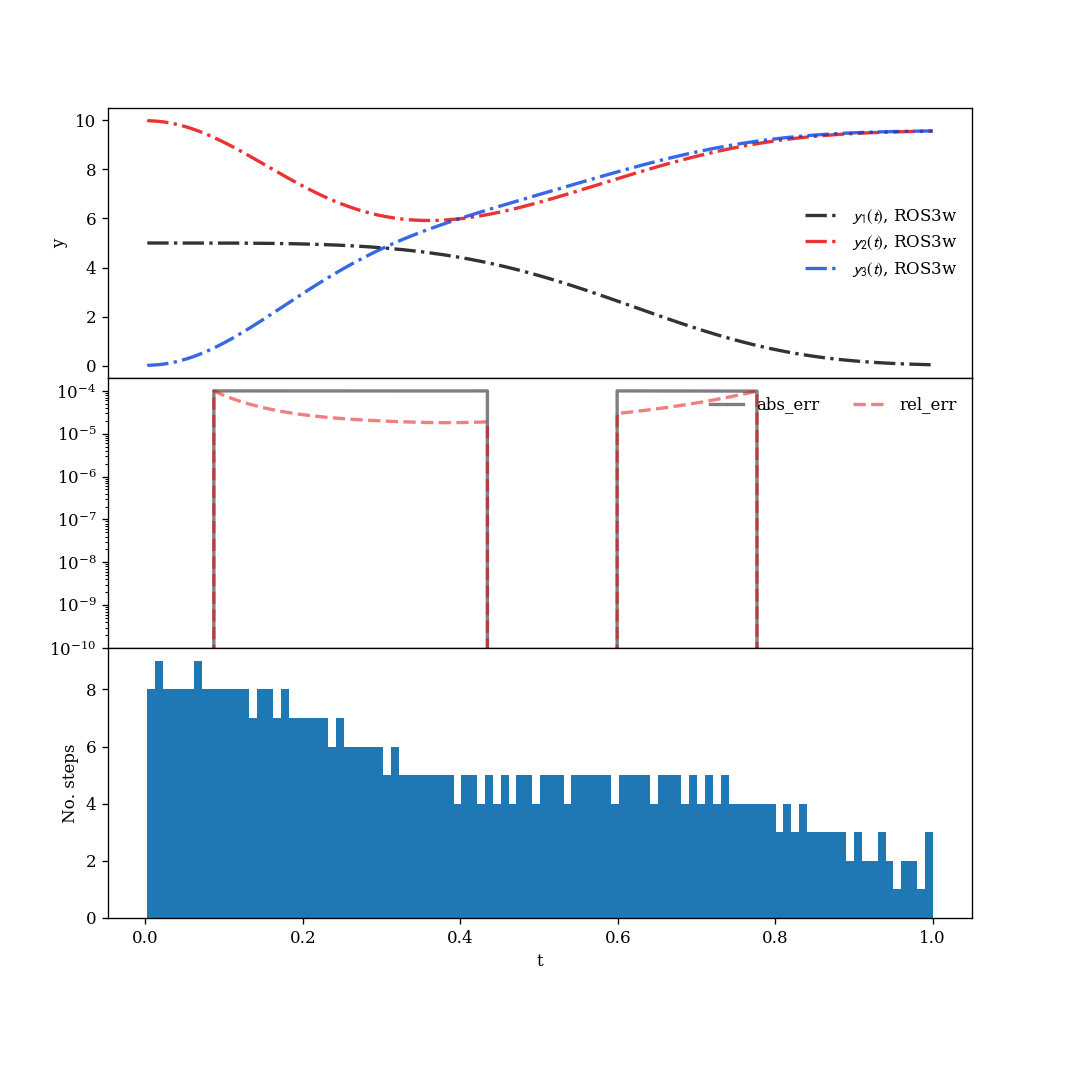

In [8]:
fig=plt.figure(figsize=(9,9))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)
fig.suptitle('')



_c=['xkcd:black','xkcd:red','xkcd:blue']
sub = fig.add_subplot(311)
for i in range(len(sol.y)):
    sub.plot(sol.t,sol.y[i],c=_c[i],alpha=0.8,linestyle='-.',linewidth=2,label=r'$y_{'+str(i+1)+'}(t)$, ROS3w') 
    #sub.scatter(sol1.t,sol1.y[i],c=_c[i],marker='.',alpha=0.5,s=0.05) 
    sub.set_ylabel('y')  
sub.legend(framealpha=0,ncol=1,loc='center right',bbox_to_anchor=(1,0.5))

sub = fig.add_subplot(312)    
sub.plot(sol.t,sol.deltas[0],c=_c[0],alpha=0.5,linestyle='-',linewidth=2,label="abs_err")
sub.plot(sol.t,sol.deltas[1],c=_c[1],alpha=0.5,linestyle='--',linewidth=2,label="rel_err")
sub.legend(framealpha=0,ncol=2,loc='center right',bbox_to_anchor=(1,.9))

    
if max(sol.deltas[0]) != 0 and max(sol.deltas[1]) != 0: 
    sub.set_ylim(max([min([min(sol.deltas[0]),min(sol.deltas[1])]),1e-10]),max([max(sol.deltas[0]),max(sol.deltas[1])])*2 )
    sub.set_yscale('log')
else:
    sub.set_ylim(max([min(sol.deltas[0]),min(sol.deltas[1]) ] ) ,max([max(sol.deltas[0]),max(sol.deltas[1])]) )


sub = fig.add_subplot(313)    
sub.hist(sol.t,bins=100)
sub.set_ylabel('No. steps')
    
sub.set_xlabel('t')  


plt.show()